In [ ]:
import numpy as np
import os
import re

# File paths
primary_categories_path = "./primary_categories_reduced.txt"
timestamps_path = "./raw_timestamps_reduced.txt"
output_folder = "./reduced_labels"

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Load instrument group mapping
instrument_groups = {
    0: "Piano",
    1: "Guitar",
    2: "Bass",
    3: "Strings",
    4: "Brass",
    5: "Reed",
    6: "Pipe",
    7: "Drums"
}

# Function to parse the primary categories file
def parse_primary_categories(file_path):
    track_instruments = {}
    with open(file_path, "r") as f:
        current_track = None
        for line in f:
            line = line.strip()
            if line.startswith("Track:"):
                current_track = re.search(r"Track(\d+)", line).group(1)
                track_instruments[current_track] = {}
            elif ".flac" in line:
                parts = line.split(": ")
                if len(parts) == 2:
                    flac_file = parts[0].strip()
                    category = int(parts[1].strip())
                    track_instruments[current_track][flac_file] = category
    return track_instruments

# Function to parse the raw timestamps file
def parse_timestamps(file_path):
    track_timestamps = {}
    with open(file_path, "r") as f:
        current_track = None
        for line in f:
            line = line.strip()
            if line.startswith("Track:"):
                current_track = re.search(r"Track(\d+)", line).group(1)
                track_timestamps[current_track] = {}
            elif ".flac" in line:
                parts = line.split(": ")
                if len(parts) == 2:
                    flac_file = parts[0].strip()
                    intervals = eval(parts[1].strip())  # Convert string to list of tuples
                    track_timestamps[current_track][flac_file] = intervals
    return track_timestamps


In [10]:
# Load data
track_instruments = parse_primary_categories(primary_categories_path)
track_timestamps = parse_timestamps(timestamps_path)

# Process each track
for track_id in track_instruments.keys():
    max_time = 0  # Track the maximum time duration
    for flac_file, intervals in track_timestamps.get(track_id, {}).items():
        for start, end in intervals:
            max_time = max(max_time, int(end))

    # Create a matrix of shape (8, max_time+1)
    instrument_matrix = np.zeros((8, max_time + 1), dtype=int)

    # Populate the matrix with active time intervals
    for flac_file, instrument_group in track_instruments[track_id].items():
        if flac_file in track_timestamps.get(track_id, {}):
            for start, end in track_timestamps[track_id][flac_file]:
                start_idx = int(start)
                end_idx = int(end)
                instrument_matrix[instrument_group, start_idx:end_idx+1] = 1

    # Save the matrix as .npy
    npy_file_path = os.path.join(output_folder, f"Track{track_id}.npy")
    np.save(npy_file_path, instrument_matrix)

print(f"Processed {len(track_instruments)} tracks. .npy files saved in {output_folder}.")

Processed 151 tracks. .npy files saved in ./reduced_test_labels.


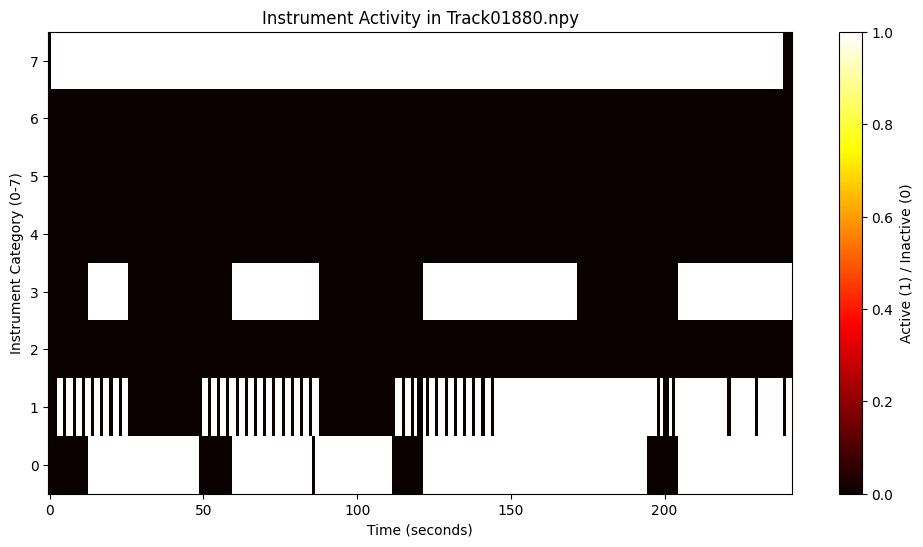

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

def display_npy_heatmap(npy_file_path):
    # Load the .npy file
    instrument_matrix = np.load(npy_file_path)

    # Create the heatmap
    plt.figure(figsize=(12, 6))
    plt.imshow(instrument_matrix, aspect='auto', cmap='hot', origin='lower')

    # Labels and colorbar
    plt.xlabel("Time (seconds)")
    plt.ylabel("Instrument Category (0-7)")
    plt.title(f"Instrument Activity in {npy_file_path.split('/')[-1]}")
    plt.colorbar(label="Active (1) / Inactive (0)")

    # Show the heatmap
    plt.show()

# Example usage:
# Replace this with the actual path to your .npy file
npy_file_path = "reduced_labels/Track01500.npy"
display_npy_heatmap(npy_file_path)
